<a href="https://colab.research.google.com/github/mikexie360/data-visualization-final-project/blob/main/data_visualization_final_project_using_ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicing wins and loses based off of pro Dota 2 teams
Predicting which teams will win or lose

Visit the github for the datasets to import
https://github.com/mikexie360/data-visualization-final-project

In [12]:
from joblib import load
import re, time
import numpy as np
import pandas as pd
import json, math, random
from collections import defaultdict, Counter
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import time, random


In [2]:
def load_prematch_histgb(artifact_path="prematch_histgb_artifacts.joblib",
                         team_pool_override: dict | None = None):
    art = load(artifact_path)
    FEATURE_NAMES = art["feature_names"]
    clf = art["clf"]
    iso = art.get("calibrator", None)
    TEAM_POOL = team_pool_override if team_pool_override is not None else art["team_pool"]
    TEAM_INDEX = art["team_index"]

    def _resolve_team_id(obj):
        # accepts int IDs or names (case-insensitive)
        if isinstance(obj, (int, np.integer)):
            return int(obj)
        s = str(obj).strip()
        lut = TEAM_INDEX["name_to_id"]
        tid = lut.get(s, lut.get(s.lower()))
        if tid is None:
            # helpful message with suggestions
            candidates = list(TEAM_INDEX["id_to_name"].values())
            hint = get_close_matches(s, candidates, n=3, cutoff=0.6)
            raise ValueError(f"Team not found: {s}. Close matches: {hint}")
        return int(tid)

    def build_features_for_teams_histgb(radiant_team_id:int,
                                        dire_team_id:int,
                                        *,
                                        patch_num: float | None = 7.39) -> pd.DataFrame:
        row = {c: 0.0 for c in FEATURE_NAMES}
        if "patch_num" in row and patch_num is not None:
            row["patch_num"] = float(patch_num)
        if "start_time" in row:
            row["start_time"] = float(time.time())

        def _fill_side(team_id: int, prefix: str):
            pool = TEAM_POOL.get(int(team_id), {})
            for hk, stats in pool.items():
                g = f"{prefix}{hk}_games";   w = f"{prefix}{hk}_wins";   r = f"{prefix}{hk}_winrate"
                if g in row: row[g] = stats["games"]
                if w in row: row[w] = stats["wins"]
                if r in row: row[r] = stats["winrate"]

        _fill_side(radiant_team_id, "radiant_team_")
        _fill_side(dire_team_id,    "dire_team_")
        return pd.DataFrame([row]).reindex(columns=FEATURE_NAMES).fillna(0.0)

    def predict_prematch_histgb(radiant_team, dire_team, *,
                                by="auto", patch_num=7.39, symmetrize=True):
        # by="auto" — int → id, str → name
        r_id = _resolve_team_id(radiant_team)
        d_id = _resolve_team_id(dire_team)

        Xa = build_features_for_teams_histgb(r_id, d_id, patch_num=patch_num)
        p_ab = float(clf.predict_proba(Xa)[:,1][0])
        if iso is not None:
            p_ab = float(iso.transform([p_ab])[0])

        if not symmetrize:
            return {"radiant_team_id": r_id, "dire_team_id": d_id,
                    "p_radiant_win": p_ab, "p_dire_win": 1.0 - p_ab}

        Xb = build_features_for_teams_histgb(d_id, r_id, patch_num=patch_num)
        p_ba = float(clf.predict_proba(Xb)[:,1][0])
        if iso is not None:
            p_ba = float(iso.transform([p_ba])[0])

        p_sym = 0.5 * (p_ab + (1.0 - p_ba))
        return {"radiant_team_id": r_id, "dire_team_id": d_id,
                "p_radiant_win_raw": p_ab, "p_radiant_win_sym": p_sym, "p_dire_win_sym": 1.0 - p_sym}

    # Optional helpers
    def list_teams(n=20):
        items = sorted(TEAM_INDEX["id_to_name"].items(), key=lambda kv: kv[1].lower())
        return items[:n]

    return predict_prematch_histgb, {"list_teams": list_teams, "team_index": TEAM_INDEX}

In [3]:
predict_prematch_histgb, utils = load_prematch_histgb("prematch_histgb_artifacts.joblib")


print(predict_prematch_histgb(2163, 8260983, patch_num=7.39, symmetrize=True))
print(predict_prematch_histgb(8260983, 2163, by="id", patch_num=7.39, symmetrize=True))
print(predict_prematch_histgb(7121114, 2163, by="id", patch_num=7.39, symmetrize=True))
print(predict_prematch_histgb(2163, 7121114, by="id", patch_num=7.39, symmetrize=True))

print(predict_prematch_histgb("Team Spirit", "BetBoom Team", by="name", symmetrize=True))
print(predict_prematch_histgb("BetBoom Team", "Team Spirit", by="name", symmetrize=True))

print(predict_prematch_histgb("Team Spirit", "Team Spirit", by="name", symmetrize=True))
print(predict_prematch_histgb("BetBoom Team", "BetBoom Team", by="name", symmetrize=True))

{'radiant_team_id': 2163, 'dire_team_id': 8260983, 'p_radiant_win_raw': 0.6035714285714285, 'p_radiant_win_sym': 0.599020737327189, 'p_dire_win_sym': 0.40097926267281103}
{'radiant_team_id': 8260983, 'dire_team_id': 2163, 'p_radiant_win_raw': 0.4055299539170507, 'p_radiant_win_sym': 0.4009792626728111, 'p_dire_win_sym': 0.599020737327189}
{'radiant_team_id': 7121114, 'dire_team_id': 2163, 'p_radiant_win_raw': 0.4055299539170507, 'p_radiant_win_sym': 0.25276497695852534, 'p_dire_win_sym': 0.7472350230414746}
{'radiant_team_id': 2163, 'dire_team_id': 7121114, 'p_radiant_win_raw': 0.9, 'p_radiant_win_sym': 0.7472350230414746, 'p_dire_win_sym': 0.2527649769585254}
{'radiant_team_id': 8965065, 'dire_team_id': 8255888, 'p_radiant_win_raw': 0.4055299539170507, 'p_radiant_win_sym': 0.37257629771324235, 'p_dire_win_sym': 0.6274237022867577}
{'radiant_team_id': 8255888, 'dire_team_id': 8965065, 'p_radiant_win_raw': 0.660377358490566, 'p_radiant_win_sym': 0.6274237022867577, 'p_dire_win_sym': 0.3

In [4]:
## teams that will be participating in TI 2025

## Team name, team_id

# Direct Invites
## Team Liquid, 2163
## PARIVISION, 9572001
## BetBoom Team, 8255888
## Team Tidebound, 9640842
## Gaimin Gladiators, 8599101
## Team Spirit, 7119388
## Team Falcons, 9247354
## Tundra Esports, 8291895

# Regional Qualifiers
## Natus Vincere, 36
## Nigma Galaxy, 7554697
## Aurora Gaming, 9467224
## Xtreme Gaming, 8261500
## Team Nemesis, 9691969
## BOOM Esports, 7732977
## Wildcard, 8606828
## HEROIC, 9303484

ti2025 = {
  "event": "The International",
  "year": 2025,
  "teams": [
    { "name": "Team Liquid",         "team_id": 2163,    "invitation_type": "direct_invite", "seed": 1 },
    { "name": "PARIVISION",          "team_id": 9572001, "invitation_type": "direct_invite", "seed": 2 },
    { "name": "BetBoom Team",        "team_id": 8255888, "invitation_type": "direct_invite", "seed": 3 },
    { "name": "Team Tidebound",      "team_id": 9640842, "invitation_type": "direct_invite", "seed": 4 },
    { "name": "Gaimin Gladiators",   "team_id": 8599101, "invitation_type": "direct_invite", "seed": 5 },
    { "name": "Team Spirit",         "team_id": 7119388, "invitation_type": "direct_invite", "seed": 6 },
    { "name": "Team Falcons",        "team_id": 9247354, "invitation_type": "direct_invite", "seed": 7 },
    { "name": "Tundra Esports",      "team_id": 8291895, "invitation_type": "direct_invite", "seed": 8 },

    { "name": "Natus Vincere",       "team_id": 36,      "invitation_type": "regional_qualifier", "seed": 9 },
    { "name": "Nigma Galaxy",        "team_id": 7554697, "invitation_type": "regional_qualifier", "seed": 10 },
    { "name": "Aurora Gaming",       "team_id": 9467224, "invitation_type": "regional_qualifier", "seed": 11 },
    { "name": "Xtreme Gaming",       "team_id": 8261500, "invitation_type": "regional_qualifier", "seed": 12 },
    { "name": "Team Nemesis",        "team_id": 9691969, "invitation_type": "regional_qualifier", "seed": 13 },
    { "name": "BOOM Esports",        "team_id": 7732977, "invitation_type": "regional_qualifier", "seed": 14 },
    { "name": "Wildcard",            "team_id": 8606828, "invitation_type": "regional_qualifier", "seed": 15 },
    { "name": "HEROIC",              "team_id": 9303484, "invitation_type": "regional_qualifier", "seed": 16 }
  ]
}


In [10]:
# ============================================================
# TI2025 Tournament Simulator (Swiss w/ 4W-4L stop + DE playoffs)
# Outputs: Reach Odds for buckets/stages, incl. R5 4-0/0-4 & Swiss Final Buckets
# ============================================================

import json
from collections import defaultdict, Counter
import numpy as np
import pandas as pd

# ---------------------------------
# Load teams & helpers (expects ti2025 defined)
# ---------------------------------
teams_df = pd.DataFrame(ti2025["teams"])
TEAM_IDS = teams_df["team_id"].tolist()
ID2NAME = dict(zip(teams_df.team_id, teams_df.name))

# Optional global seed order from JSON (if present)
SEED_ORDER = None
if "seed" in teams_df.columns and teams_df["seed"].notna().all():
    if len(set(teams_df["seed"])) == len(teams_df):
        SEED_ORDER = teams_df.sort_values("seed")["team_id"].tolist()

# -----------------------------
# Pretty-print helpers
# -----------------------------
def _mk_df_from_counter(counter: Counter, N: int) -> pd.DataFrame:
    rows = []
    for tid, c in counter.items():
        rows.append({"team_id": int(tid), "team": ID2NAME.get(tid, str(tid)), "prob": c / N})
    df = pd.DataFrame(rows) if rows else pd.DataFrame(columns=["team_id","team","prob"])
    return df.sort_values("prob", ascending=False).reset_index(drop=True)

def _print_prob_table(df: pd.DataFrame, title: str, prob_col="prob", label="reach_odds"):
    print(f"\n=== {title} ===")
    if df.empty:
        print("(none)")
        return
    df2 = df.copy()
    df2[prob_col] = df2[prob_col].map(lambda x: float(f"{x:.4f}"))
    print(df2.rename(columns={prob_col: label}))

# -----------------------------
# 0) Predictors / RNG  (precompute 16x16 prob matrix)
# -----------------------------
rng = np.random.default_rng(42)

def _coerce01(x: float) -> float:
    # keep probabilities in [0,1] with tiny numeric safety
    return float(min(1.0, max(0.0, x)))

def build_prob_matrix(team_ids, predict_prematch_histgb_func=None):
    """
    Returns dict[int, dict[int, float]] mapping teamA -> teamB -> P(A beats B).
    If predict_prematch_histgb_func is None, builds a 0.5 coin-flip matrix.
    """
    matrix = {int(a): {} for a in team_ids}

    if predict_prematch_histgb_func is None:
        # uniform 50/50
        for a in team_ids:
            for b in team_ids:
                matrix[int(a)][int(b)] = 0.5 if a != b else 0.5
        return matrix

    # Use the ML model once per unordered pair; enforce symmetry
    for i, a in enumerate(team_ids):
        a = int(a)
        for j, b in enumerate(team_ids):
            b = int(b)
            if a == b:
                matrix[a][b] = 0.5
            elif b in matrix and a in matrix[b]:
                # fill from symmetry computed earlier
                matrix[a][b] = _coerce01(1.0 - matrix[b][a])
            else:
                out = predict_prematch_histgb_func(a, b, by="id", symmetrize=True)
                p_ab = _coerce01(float(out["p_radiant_win_sym"]))
                matrix[a][b] = p_ab
                matrix[b][a] = _coerce01(1.0 - p_ab)
    return matrix

def save_prob_matrix_json(matrix, path: str):
    # note: JSON forces dict keys to strings
    with open(path, "w", encoding="utf-8") as f:
        json.dump(matrix, f, indent=2)

def load_prob_matrix_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    # convert keys back to ints
    fixed = {int(a): {int(b): float(p) for b, p in row.items()} for a, row in raw.items()}
    return fixed

def make_lookup_predictor(prob_matrix):
    """predictor(a_id, b_id) -> P(A beats B) via dict lookup"""
    def predictor(a_id, b_id):
        a = int(a_id); b = int(b_id)
        if a == b:
            return 0.5
        return float(prob_matrix[a][b])
    return predictor

# Try to load the ML model and precompute the matrix once
try:
    predict_prematch_histgb, _ = load_prematch_histgb("prematch_histgb_artifacts.joblib")
    PROB_MATRIX = build_prob_matrix(TEAM_IDS, predict_prematch_histgb_func=predict_prematch_histgb)
    # Optional: save for later reuse (skip if you don't want a file)
    # save_prob_matrix_json(PROB_MATRIX, "ti2025_prob_matrix.json")
except Exception as e:
    print("⚠️ Could not load prematch model; using 50/50 coin matrix. Reason:", e)
    PROB_MATRIX = build_prob_matrix(TEAM_IDS, predict_prematch_histgb_func=None)

# Use fast lookup predictor everywhere else (no other code changes needed)
PROB_MATRIX = build_prob_matrix(TEAM_IDS, predict_prematch_histgb_func=predict_prematch_histgb)
predictor = make_lookup_predictor(PROB_MATRIX)

def _pA(a_id, b_id, predictor):
    return float(predictor(a_id, b_id))

def play_game(a_id, b_id, predictor):
    p = _pA(a_id, b_id, predictor)
    winA = (rng.random() < p)
    return winA, p


def play_boN(a_id, b_id, predictor, N=3, label=""):
    """Return (winner_id, scoreA, scoreB, series_log)."""
    need = N//2 + 1
    a_wins = 0
    b_wins = 0
    games = []
    gnum = 0
    while a_wins < need and b_wins < need:
        gnum += 1
        winA, p = play_game(a_id, b_id, predictor)
        if winA: a_wins += 1
        else:     b_wins += 1
        games.append({
            "game": gnum,
            "pA": p,
            "winner": ID2NAME[a_id] if winA else ID2NAME[b_id],
            "scoreA_running": a_wins,
            "scoreB_running": b_wins
        })
    winner = a_id if a_wins > b_wins else b_id
    series_log = {
        "label": label,
        "best_of": N,
        "A": {"id": int(a_id), "name": ID2NAME[a_id]},
        "B": {"id": int(b_id), "name": ID2NAME[b_id]},
        "games": games,
        "final_score": [a_wins, b_wins],
        "winner": {"id": int(winner), "name": ID2NAME[winner]},
    }
    return winner, a_wins, b_wins, series_log

def play_bo3(a_id, b_id, predictor, label=""): return play_boN(a_id, b_id, predictor, 3, label)
def play_bo5(a_id, b_id, predictor, label=""): return play_boN(a_id, b_id, predictor, 5, label)

# ======================================================
# 1) Swiss system (5 rounds; stop at 4W/4L; same-record)
# ======================================================
def swiss_group_stage(team_ids,
                      predictor,
                      verbose=True,
                      random_seeding=True,          # R1 random by default
                      seed_order=None,              # list of team_ids in seed order
                      pairing_style="1v16"          # "1v16" or "adjacent"
                      ):
    """
    TI 2025 Swiss:
      - 5 rounds of Bo3
      - R2..R5 pair ONLY within same current record (x-y).
      - Teams stop once they hit 4 wins (advance) or 4 losses (eliminated).
    """
    records = {tid: [0,0] for tid in team_ids}
    opponents = {tid: [] for tid in team_ids}
    played = set()  # (min(a,b), max(a,b)) to avoid rematches
    swiss_log = {"rounds": [], "config": {
        "random_seeding": bool(random_seeding),
        "pairing_style": pairing_style,
        "seed_order": [int(x) for x in (seed_order or [])]
    }}

    def key_pair(a,b): return (a,b) if a<b else (b,a)

    def _pair_bucket_strict(bucket_teams):
        """
        Pair strictly within this list (even-sized), avoiding rematches if possible.
        Tries multiple shuffles to avoid rematches; falls back to allowing if necessary.
        """
        teams = bucket_teams[:]
        assert len(teams) % 2 == 0, "Bucket has odd size; Swiss should keep buckets even."
        for _ in range(200):
            rng.shuffle(teams)
            ok = True
            pairs = []
            for i in range(0, len(teams), 2):
                a, b = teams[i], teams[i+1]
                if key_pair(a,b) in played:
                    ok = False
                    break
                pairs.append((a,b))
            if ok:
                return pairs
        # Fallback: allow rematch minimally
        pairs = []
        for i in range(0, len(teams), 2):
            pairs.append((teams[i], teams[i+1]))
        return pairs

    # Play exactly 5 rounds, with active teams only
    for rnd in range(1, 6):
        # Active = teams that haven't reached 4W/4L yet
        active = [t for t,(w,l) in records.items() if w < 4 and l < 4]

        # Group active teams by current record
        buckets = defaultdict(list)
        for t in active:
            w,l = records[t]
            buckets[(w,l)].append(t)

        # Snapshot BEFORE pairings (active buckets only)
        bucket_ids   = {f"{w}-{l}": [int(t) for t in tids] for (w,l), tids in buckets.items()}
        bucket_names = {k: [ID2NAME[t] for t in v] for k, v in bucket_ids.items()}
        if verbose:
            print(f"\n[Swiss] Round {rnd}: buckets = {bucket_names}")

        # ---------------- Pairings ----------------
        round_pairs = []

        if rnd == 1:
            # Round 1 uses all 0-0 teams
            s = buckets.get((0,0), [])[:]
            assert len(s) == 16, "Round-1 expects all 16 teams at 0-0."
            if random_seeding:
                rng.shuffle(s)
                for i in range(0, 16, 2):
                    round_pairs.append((s[i], s[i+1]))
            else:
                use_order = seed_order or SEED_ORDER
                assert use_order is not None, "No seed_order provided and SEED_ORDER not available."
                assert set(use_order) == set(team_ids), "seed_order must list all 16 team_ids exactly once."
                s = [t for t in use_order if t in s]
                if pairing_style == "1v16":
                    for i in range(8):
                        round_pairs.append((s[i], s[-(i+1)]))
                elif pairing_style == "adjacent":
                    for i in range(0, 16, 2):
                        round_pairs.append((s[i], s[i+1]))
                else:
                    raise ValueError("pairing_style must be '1v16' or 'adjacent'")
        else:
            # R2..R5: strictly same-record pairings, higher-win buckets first
            for (w,l), group in sorted(buckets.items(), key=lambda kv: (-kv[0][0], kv[0][1])):
                if len(group) == 0:
                    continue
                # Swiss parity guarantees even group sizes here
                assert len(group) % 2 == 0, f"Bucket {w}-{l} has odd size {len(group)}."
                pairs = _pair_bucket_strict(group)
                round_pairs.extend(pairs)

        if verbose:
            print(f"[Swiss] Round {rnd} pairings:",
                  [(ID2NAME[a], ID2NAME[b]) for a,b in round_pairs])

        # ---------------- Play & log ----------------
        matches_log = []
        for idx,(a,b) in enumerate(round_pairs, start=1):
            played.add(key_pair(a,b))
            label = f"Swiss R{rnd} M{idx}: {ID2NAME[a]} vs {ID2NAME[b]}"
            winner, wa, wb, s_log = play_bo3(a,b,predictor,label=label)
            loser = b if winner==a else a
            records[winner][0] += 1
            records[loser][1]  += 1
            opponents[a].append(b)
            opponents[b].append(a)
            matches_log.append(s_log)
            if verbose:
                print(f"  - {label} -> {ID2NAME[winner]} {wa}-{wb}  "
                      f"(new records: {ID2NAME[a]} {records[a]}, {ID2NAME[b]} {records[b]})")

        swiss_log["rounds"].append({
            "round": rnd,
            "buckets_ids": bucket_ids,         # BEFORE the round (active only)
            "buckets_names": bucket_names,
            "pairings": [{"A": int(a), "B": int(b)} for a,b in round_pairs],
            "matches": matches_log,
            "records_after": {int(t): records[t][:] for t in records}  # AFTER the round
        })

    # Sanity check: (expected 3&3 but we don't hard fail if randomness breaks parity)
    if verbose:
        four_w = sum(1 for t,(w,l) in records.items() if w >= 4)
        four_l = sum(1 for t,(w,l) in records.items() if l >= 4)
        print(f"\n[Swiss] Sanity: 4W={four_w}, 4L={four_l}")

    return records, opponents, swiss_log

def swiss_rank(records, opponents, verbose=True):
    """Rank by: wins desc, losses asc, Buchholz (sum of opp wins), then random."""
    opp_wins = {}
    for t, opps in opponents.items():
        opp_wins[t] = sum(records[o][0] for o in opps)
    items = list(records.items())  # [(tid,[w,l])]
    rng.shuffle(items)  # randomness for unresolved ties
    items.sort(key=lambda kv: (-kv[1][0], kv[1][1], -opp_wins[kv[0]]))
    order = [tid for tid,_ in items]
    if verbose:
        print("\n[Swiss] Final standings (pre-seed):")
        for rank, tid in enumerate(order, start=1):
            w,l = records[tid]
            print(f"  {rank:2d}. {ID2NAME[tid]}  W-L={w}-{l}  Buchholz={opp_wins[tid]}")
    rank_log = {"order": [int(x) for x in order],
                "buchholz": {int(k): int(v) for k,v in opp_wins.items()}}
    return order, rank_log

# -----------------------------
# 2) Special Elimination Round (10 teams -> 5 winners)
# -----------------------------
def elimination_round(swiss_order, predictor, verbose=True):
    # Teams ranked 4..13 play: 4v13, 5v12, 6v11, 7v10, 8v9
    seeds = swiss_order
    play_ids = seeds[3:13]
    pairings = [(play_ids[0], play_ids[-1]),
                (play_ids[1], play_ids[-2]),
                (play_ids[2], play_ids[-3]),
                (play_ids[3], play_ids[-4]),
                (play_ids[4], play_ids[-5])]
    winners = []
    elim_log = {"pairings": [], "matches": []}
    if verbose:
        print("\n[Elimination Round] Pairings (Bo3):",
              [(ID2NAME[a], ID2NAME[b]) for a,b in pairings])
    for a,b in pairings:
        label = f"Elim: {ID2NAME[a]} vs {ID2NAME[b]}"
        w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
        winners.append(w)
        elim_log["pairings"].append({"A": int(a), "B": int(b)})
        elim_log["matches"].append(s_log)
        if verbose:
            print(f"  - {label} -> {ID2NAME[w]} {wa}-{wb}")
    elim_log["winners"] = [int(x) for x in winners]
    return winners, elim_log

# -----------------------------
# 3) Double-Elim Playoffs (8 teams; all start UB)
# -----------------------------
def simulate_playoffs(swiss_order, elim_winners, predictor, verbose=True):
    top3 = swiss_order[:3]
    playoff_teams = top3 + elim_winners
    order = {tid:i for i,tid in enumerate(swiss_order)}
    playoff_teams.sort(key=lambda t: order[t])
    seeds = playoff_teams

    log = {"seeds": [int(x) for x in seeds], "UB": {}, "LB": {}, "GF": None}

    if verbose:
        print("\n[Playoffs] Seeds (1..8):",
              [(i+1, ID2NAME[s]) for i,s in enumerate(seeds)])

    # UB QF
    qf_pairs = [(seeds[0],seeds[7]), (seeds[3],seeds[4]),
                (seeds[2],seeds[5]), (seeds[1],seeds[6])]
    if verbose: print("[UB] Quarterfinals:", [(ID2NAME[a],ID2NAME[b]) for a,b in qf_pairs])
    ub_qf_winners, lb_losses = [], []
    log["UB"]["QF"] = []
    for a,b in qf_pairs:
        label = f"UB QF: {ID2NAME[a]} vs {ID2NAME[b]}"
        w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
        l = b if w==a else a
        ub_qf_winners.append(w)
        lb_losses.append(l)
        log["UB"]["QF"].append(s_log)
        if verbose: print(f"  - {label} -> {ID2NAME[w]} {wa}-{wb}")

    # UB SF
    ub_sf_pairs = [(ub_qf_winners[0], ub_qf_winners[1]),
                   (ub_qf_winners[2], ub_qf_winners[3])]
    if verbose: print("[UB] Semifinals:", [(ID2NAME[a],ID2NAME[b]) for a,b in ub_sf_pairs])
    ub_sf_winners = []
    log["UB"]["SF"] = []
    for a,b in ub_sf_pairs:
        label = f"UB SF: {ID2NAME[a]} vs {ID2NAME[b]}"
        w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
        l = b if w==a else a
        ub_sf_winners.append(w)
        lb_losses.append(l)
        log["UB"]["SF"].append(s_log)
        if verbose: print(f"  - {label} -> {ID2NAME[w]} {wa}-{wb}")

    # UB Final
    a,b = ub_sf_winners
    label = f"UB Final: {ID2NAME[a]} vs {ID2NAME[b]}"
    ub_final_w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
    ub_final_l = b if ub_final_w==a else a
    lb_losses.append(ub_final_l)
    log["UB"]["Final"] = s_log
    if verbose: print(f"[UB] Final -> {ID2NAME[ub_final_w]} {wa}-{wb}")

    # LB R1
    lb = lb_losses[:]  # [QF-L1, QF-L2, QF-L3, QF-L4, SF-L1, SF-L2, UB-Final-L]
    lb_r1_pairs = [(lb[0], lb[1]), (lb[2], lb[3])]
    if verbose: print("[LB] Round 1:", [(ID2NAME[a],ID2NAME[b]) for a,b in lb_r1_pairs])
    log["LB"]["R1"] = []
    lb_r1_w = []
    for a,b in lb_r1_pairs:
        label = f"LB R1: {ID2NAME[a]} vs {ID2NAME[b]}"
        w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
        lb_r1_w.append(w)
        log["LB"]["R1"].append(s_log)
        if verbose: print(f"  - {label} -> {ID2NAME[w]} {wa}-{wb}")

    # LB R2
    sf_losers = lb[4:6]
    lb_r2_pairs = [(lb_r1_w[0], sf_losers[0]), (lb_r1_w[1], sf_losers[1])]
    if verbose: print("[LB] Round 2:", [(ID2NAME[a],ID2NAME[b]) for a,b in lb_r2_pairs])
    log["LB"]["R2"] = []
    lb_r2_w = []
    for a,b in lb_r2_pairs:
        label = f"LB R2: {ID2NAME[a]} vs {ID2NAME[b]}"
        w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
        lb_r2_w.append(w)
        log["LB"]["R2"].append(s_log)
        if verbose: print(f"  - {label} -> {ID2NAME[w]} {wa}-{wb}")

    # LB QF
    a,b = lb_r2_w
    label = f"LB QF: {ID2NAME[a]} vs {ID2NAME[b]}"
    lb_qf_w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
    log["LB"]["QF"] = s_log
    if verbose: print(f"[LB] QF -> {ID2NAME[lb_qf_w]} {wa}-{wb}")

    # LB Final
    a,b = lb_qf_w, ub_final_l
    label = f"LB Final: {ID2NAME[a]} vs {ID2NAME[b]}"
    lb_final_w,wa,wb, s_log = play_bo3(a,b,predictor,label=label)
    log["LB"]["Final"] = s_log
    if verbose: print(f"[LB] Final -> {ID2NAME[lb_final_w]} {wa}-{wb}")

    # Grand Final (Bo5)
    a,b = ub_final_w, lb_final_w
    label = f"Grand Final: {ID2NAME[a]} vs {ID2NAME[b]}"
    champion,wa,wb, s_log = play_bo5(a,b,predictor,label=label)
    log["GF"] = s_log
    if verbose: print(f"[GF] {ID2NAME[champion]} wins {wa}-{wb}!")

    return champion, log

# -----------------------------
# 4) Full tournament simulation (returns full log)
# -----------------------------
def simulate_once(team_ids, predictor, verbose=True,
                  # Swiss R1 seeding controls
                  random_seeding=True,
                  pairing_style="1v16",
                  seed_order=None):
    run_log = {"teams": [{"id": int(t), "name": ID2NAME[t]} for t in team_ids]}

    # Swiss
    records, opponents, swiss_log = swiss_group_stage(
        team_ids, predictor, verbose=verbose,
        random_seeding=random_seeding,
        seed_order=seed_order,
        pairing_style=pairing_style
    )
    order, rank_log = swiss_rank(records, opponents, verbose=verbose)
    run_log["swiss"] = {
        "rounds": swiss_log["rounds"],
        "records_final": {int(t): records[t][:] for t in records},
        "rank": rank_log,
        "config": swiss_log["config"]
    }

    # Elimination (special)
    elim_winners, elim_log = elimination_round(order, predictor, verbose=verbose)
    run_log["elimination_round"] = elim_log

    # Playoffs
    champion, po_log = simulate_playoffs(order, elim_winners, predictor, verbose=verbose)
    run_log["playoffs"] = po_log
    run_log["champion"] = {"id": int(champion), "name": ID2NAME[champion]}

    return champion, run_log

# --------------------------------------------------------
# 5) Aggregation utilities: from live runs or saved logs
# --------------------------------------------------------
def _aggregate_from_run_log(run_log, swiss_bucket_counts, swiss_final_counts,
                            elim_participation, elim_advancers, stage_counts):
    # Swiss buckets BEFORE each round (active only, by design)
    rounds = run_log["swiss"]["rounds"]
    for rnd in rounds:
        rnum = rnd["round"]
        for bucket_str, tids in rnd["buckets_ids"].items():
            for tid in tids:
                swiss_bucket_counts[rnum][bucket_str][tid] += 1

    # Add terminal buckets (4-0 and 0-4) as present *at the start of R5*
    # i.e., after R4 is completed.
    r4 = next((r for r in rounds if r["round"] == 4), None)
    if r4 is not None:
        rec_after_r4 = r4["records_after"]
        for tid, wl in rec_after_r4.items():
            w, l = wl
            if w >= 4:
                swiss_bucket_counts[5]["4-0"][int(tid)] += 1  # auto-advanced after 4 rounds
            if l >= 4:
                swiss_bucket_counts[5]["0-4"][int(tid)] += 1  # auto-eliminated after 4 rounds

    # Swiss FINAL bucket for each team (e.g., 4-1, 2-4, etc.)
    final_records = run_log["swiss"]["records_final"]
    for tid, (w, l) in final_records.items():
        key = f"{w}-{l}"
        swiss_final_counts[key][int(tid)] += 1

    # Elimination participation (seeds 4..13) and advancement to playoffs
    order = run_log["swiss"]["rank"]["order"]
    for tid in order[3:13]:
        elim_participation[tid] += 1
    for tid in run_log["elimination_round"]["winners"]:
        elim_advancers[tid] += 1

    # Playoffs / DE stages
    po = run_log["playoffs"]

    # UB QF: all 8 seeds
    for tid in po["seeds"]:
        stage_counts["UB_QF"][tid] += 1

    # UB SF participants
    for s in po["UB"]["SF"]:
        stage_counts["UB_SF"][s["A"]["id"]] += 1
        stage_counts["UB_SF"][s["B"]["id"]] += 1

    # UB Final participants
    s = po["UB"]["Final"]
    stage_counts["UB_Final"][s["A"]["id"]] += 1
    stage_counts["UB_Final"][s["B"]["id"]] += 1

    # LB rounds participants
    for s in po["LB"]["R1"]:
        stage_counts["LB_R1"][s["A"]["id"]] += 1
        stage_counts["LB_R1"][s["B"]["id"]] += 1
    for s in po["LB"]["R2"]:
        stage_counts["LB_R2"][s["A"]["id"]] += 1
        stage_counts["LB_R2"][s["B"]["id"]] += 1

    s = po["LB"]["QF"]
    stage_counts["LB_QF"][s["A"]["id"]] += 1
    stage_counts["LB_QF"][s["B"]["id"]] += 1

    s = po["LB"]["Final"]
    stage_counts["LB_Final"][s["A"]["id"]] += 1
    stage_counts["LB_Final"][s["B"]["id"]] += 1

    # Grand Final + Champion
    s = po["GF"]
    stage_counts["GF"][s["A"]["id"]] += 1
    stage_counts["GF"][s["B"]["id"]] += 1
    stage_counts["Champion"][run_log["champion"]["id"]] += 1

def build_stats_from_logs(logs, N, team_ids=None):
    """
    Build aggregated REACH ODDS tables from saved run logs.
    IMPORTANT: N should equal the number of runs represented in `logs`.
    """
    if team_ids is None:
        if logs and "teams" in logs[0]:
            team_ids = [t["id"] for t in logs[0]["teams"]]
        else:
            team_ids = TEAM_IDS

    swiss_bucket_counts = defaultdict(lambda: defaultdict(Counter))  # round -> bucket -> Counter(team)
    swiss_final_counts  = defaultdict(Counter)  # final_bucket -> Counter(team)
    elim_participation = Counter()
    elim_advancers     = Counter()
    stage_counts = {
        "UB_QF": Counter(),
        "UB_SF": Counter(),
        "UB_Final": Counter(),
        "LB_R1": Counter(),
        "LB_R2": Counter(),
        "LB_QF": Counter(),
        "LB_Final": Counter(),
        "GF": Counter(),
        "Champion": Counter(),
    }

    for run_log in logs:
        _aggregate_from_run_log(run_log, swiss_bucket_counts, swiss_final_counts,
                                elim_participation, elim_advancers, stage_counts)

    # Convert counters -> DataFrames
    swiss_probs = {}  # round -> bucket_str -> DF (reach odds)
    for r in range(1, 6):
        if r not in swiss_bucket_counts:
            continue
        swiss_probs[r] = {}
        # sort buckets by wins desc, losses asc (so 3-1 before 2-2, etc)
        def _bkey(b):
            w,l = map(int, b.split("-"))
            return (-w, l)
        for bucket in sorted(swiss_bucket_counts[r].keys(), key=_bkey):
            swiss_probs[r][bucket] = _mk_df_from_counter(swiss_bucket_counts[r][bucket], N)

    # Final Swiss buckets (4-0, 4-1, ..., 0-4)
    def _bkey_final(b):
        w,l = map(int, b.split("-"))
        return (-w, l)
    swiss_final_probs = {}
    for bucket in sorted(swiss_final_counts.keys(), key=_bkey_final):
        swiss_final_probs[bucket] = _mk_df_from_counter(swiss_final_counts[bucket], N)

    stats = {
        "title_odds": None,  # filled elsewhere if desired
        "swiss_probs": swiss_probs,              # per-round reach odds (incl. R5 4-0/0-4)
        "swiss_final_probs": swiss_final_probs,  # final Swiss bucket reach odds
        "elim_participation": _mk_df_from_counter(elim_participation, N),
        "elim_advancers": _mk_df_from_counter(elim_advancers, N),
        "stage_probs": {k: _mk_df_from_counter(v, N) for k,v in stage_counts.items()}
    }
    return stats

def print_stats(stats):
    # Swiss buckets per round (Reach Odds)
    swiss_probs = stats["swiss_probs"]
    for r in range(1, 6):
        if r not in swiss_probs: continue
        # Print 4-0 / 0-4 if present in R5
        for bucket, df in swiss_probs[r].items():
            _print_prob_table(df, f"Swiss R{r} Bucket[{bucket}]", label="reach_odds")

    # Swiss FINAL buckets (Reach Odds of finishing Swiss at that record)
    for bucket, df in stats["swiss_final_probs"].items():
        _print_prob_table(df, f"Swiss FINAL Bucket[{bucket}]", label="reach_odds")

    # Elimination round summaries (Reach Odds)
    _print_prob_table(stats["elim_participation"], "Elimination Round: Participation Reach Odds", label="reach_odds")
    _print_prob_table(stats["elim_advancers"],     "Elimination Round: Advanced to Playoffs Reach Odds", label="reach_odds")

    # Playoff stage summaries (Reach Odds)
    for stage in ["UB_QF","UB_SF","UB_Final","LB_R1","LB_R2","LB_QF","LB_Final","GF"]:
        df = stats["stage_probs"].get(stage, pd.DataFrame(columns=["team_id","team","prob"]))
        nice = stage.replace("_", " ")
        _print_prob_table(df, f"Playoffs: Reached {nice} Reach Odds", label="reach_odds")

    # Champion (Win Prob)
    _print_prob_table(stats["stage_probs"].get("Champion", pd.DataFrame(columns=["team_id","team","prob"])),
                      "Playoffs: Reached Champion (Win Prob)", label="win_prob")

# ---------------------------------------------------------
# 6) Monte Carlo with stage aggregation & printing
# ---------------------------------------------------------
def monte_carlo(N=100, predictor=None, seed=42, verbose_every=None, capture_logs_for=None,
                # pass-through Swiss seeding controls
                random_seeding=True, pairing_style="1v16", seed_order=None):
    assert predictor is not None, "Pass a predictor function."
    globals()['rng'] = np.random.default_rng(seed)

    # Default: capture all logs so you can post-process without rerunning
    if capture_logs_for is None:
        capture_logs_for = N

    champs = []
    logs = []

    # (Optional live aggregation; we ultimately rebuild from logs)
    swiss_bucket_counts = defaultdict(lambda: defaultdict(Counter))
    swiss_final_counts  = defaultdict(Counter)
    elim_participation = Counter()
    elim_advancers     = Counter()
    stage_counts = {
        "UB_QF": Counter(),
        "UB_SF": Counter(),
        "UB_Final": Counter(),
        "LB_R1": Counter(),
        "LB_R2": Counter(),
        "LB_QF": Counter(),
        "LB_Final": Counter(),
        "GF": Counter(),
        "Champion": Counter(),
    }

    for i in range(1, N+1):
        if verbose_every and (i % verbose_every == 1):
            print("")  # spacing
        print(f"\n=== TOURNAMENT RUN {i} / {N} ===")

        champ, run_log = simulate_once(
            TEAM_IDS, predictor, verbose=True,
            random_seeding=random_seeding,
            pairing_style=pairing_style,
            seed_order=seed_order if seed_order is not None else SEED_ORDER
        )
        champs.append(champ)
        if i <= capture_logs_for:
            logs.append(run_log)

        # live aggregation (not required, but harmless)
        _aggregate_from_run_log(run_log, swiss_bucket_counts, swiss_final_counts,
                                elim_participation, elim_advancers, stage_counts)

        if verbose_every and i % verbose_every == 0:
            print(f"[MC] Completed {i}/{N}")

    # --- Title odds table (Champion win prob) ---
    counts = Counter(champs)
    title_table = pd.DataFrame({
        "team_id": TEAM_IDS,
        "team": [ID2NAME[t] for t in TEAM_IDS],
        "win_prob": [counts[t]/N for t in TEAM_IDS]
    }).sort_values("win_prob", ascending=False).reset_index(drop=True)

    # --- Build stats object (DFs) for easy re-printing later ---
    stats = build_stats_from_logs(logs, N, team_ids=TEAM_IDS)
    stats["title_odds"] = title_table

    # --- Print headline odds & stage summaries now ---
    print("\n=== Estimated Title Odds (Champion Win Prob) ===")
    print(title_table)

    # Swiss buckets per round (Reach Odds)
    for r in range(1, 6):
        if r not in stats["swiss_probs"]:
            continue
        for bucket, df in stats["swiss_probs"][r].items():
            _print_prob_table(df, f"Swiss R{r} Bucket[{bucket}]", label="reach_odds")

    # Swiss FINAL buckets (Reach Odds)
    for bucket, df in stats["swiss_final_probs"].items():
        _print_prob_table(df, f"Swiss FINAL Bucket[{bucket}]", label="reach_odds")

    # Elimination round summaries (Reach Odds)
    _print_prob_table(stats["elim_participation"], "Elimination Round: Participation Reach Odds", label="reach_odds")
    _print_prob_table(stats["elim_advancers"],     "Elimination Round: Advanced to Playoffs Reach Odds", label="reach_odds")

    # Playoff stage summaries (Reach Odds)
    for stage in ["UB_QF","UB_SF","UB_Final","LB_R1","LB_R2","LB_QF","LB_Final","GF"]:
        df = stats["stage_probs"][stage]
        nice = stage.replace("_", " ")
        _print_prob_table(df, f"Playoffs: Reached {nice} Reach Odds", label="reach_odds")

    # Champion (Win Prob)
    _print_prob_table(stats["stage_probs"]["Champion"], "Playoffs: Reached Champion (Win Prob)", label="win_prob")

    return title_table, logs, stats

# -----------------------------
# 7) Example runs
# -----------------------------
# # A) Default: Round-1 random
# win_table, run_logs, stats = monte_carlo(
#     N=100, predictor=predictor, seed=123, verbose_every=1, capture_logs_for=100,
#     random_seeding=True  # default
# )
# print("\n=== Estimated Title Odds (random R1) ===")
# print(win_table)

# # Save logs so you can print tables later without rerunning:
# with open("ti2025_mc_logs_randomR1.json", "w", encoding="utf-8") as f:
#     json.dump(run_logs, f, indent=2)

# # B) Deterministic Round-1 from JSON seeds, 1v16 (or "adjacent")
# if SEED_ORDER is not None:
#     win_table_seeded, run_logs_seeded, stats_seeded = monte_carlo(
#         N=100, predictor=predictor, seed=123, verbose_every=1, capture_logs_for=100,
#         random_seeding=False, pairing_style="1v16", seed_order=SEED_ORDER
#     )
#     print("\n=== Estimated Title Odds (seeded R1: 1v16) ===")
#     print(win_table_seeded)

#     with open("ti2025_mc_logs_seededR1_1v16.json", "w", encoding="utf-8") as f:
#         json.dump(run_logs_seeded, f, indent=2)

# -----------------------------
# 8) Reprinting later from saved logs (no rerun)
# -----------------------------
# Example:
# with open("ti2025_mc_logs_randomR1.json", "r", encoding="utf-8") as f:
#     saved_logs = json.load(f)
# stats_from_file = build_stats_from_logs(saved_logs, N=len(saved_logs), team_ids=TEAM_IDS)
# print_stats(stats_from_file)
print(PROB_MATRIX)

{2163: {2163: 0.5, 9572001: 0.6124213836477987, 8255888: 0.599020737327189, 9640842: 0.599020737327189, 8599101: 0.5, 7119388: 0.5033766233766235, 9247354: 0.4319805194805195, 8291895: 0.43003770423125265, 36: 0.5370670995670996, 7554697: 0.5934523809523808, 9467224: 0.6274237022867577, 8261500: 0.5699622957687474, 9691969: 0.6274237022867577, 7732977: 0.5310012568077084, 8606828: 0.6274237022867577, 9303484: 0.6179897400226066}, 9572001: {2163: 0.38757861635220126, 9572001: 0.5, 8255888: 0.5343778801843317, 9640842: 0.43003770423125265, 8599101: 0.40695417789757415, 7119388: 0.4009792626728111, 9247354: 0.37257629771324235, 8291895: 0.3820102599773933, 36: 0.4353571428571429, 7554697: 0.5288095238095238, 9467224: 0.5370670995670996, 8261500: 0.5033766233766235, 9691969: 0.5869884832148984, 7732977: 0.43447229403169607, 8606828: 0.5646428571428571, 9303484: 0.5}, 8255888: {2163: 0.40097926267281103, 9572001: 0.46562211981566826, 8255888: 0.5, 9640842: 0.5, 8599101: 0.3820102599773933, 

<Figure size 1500x1500 with 0 Axes>

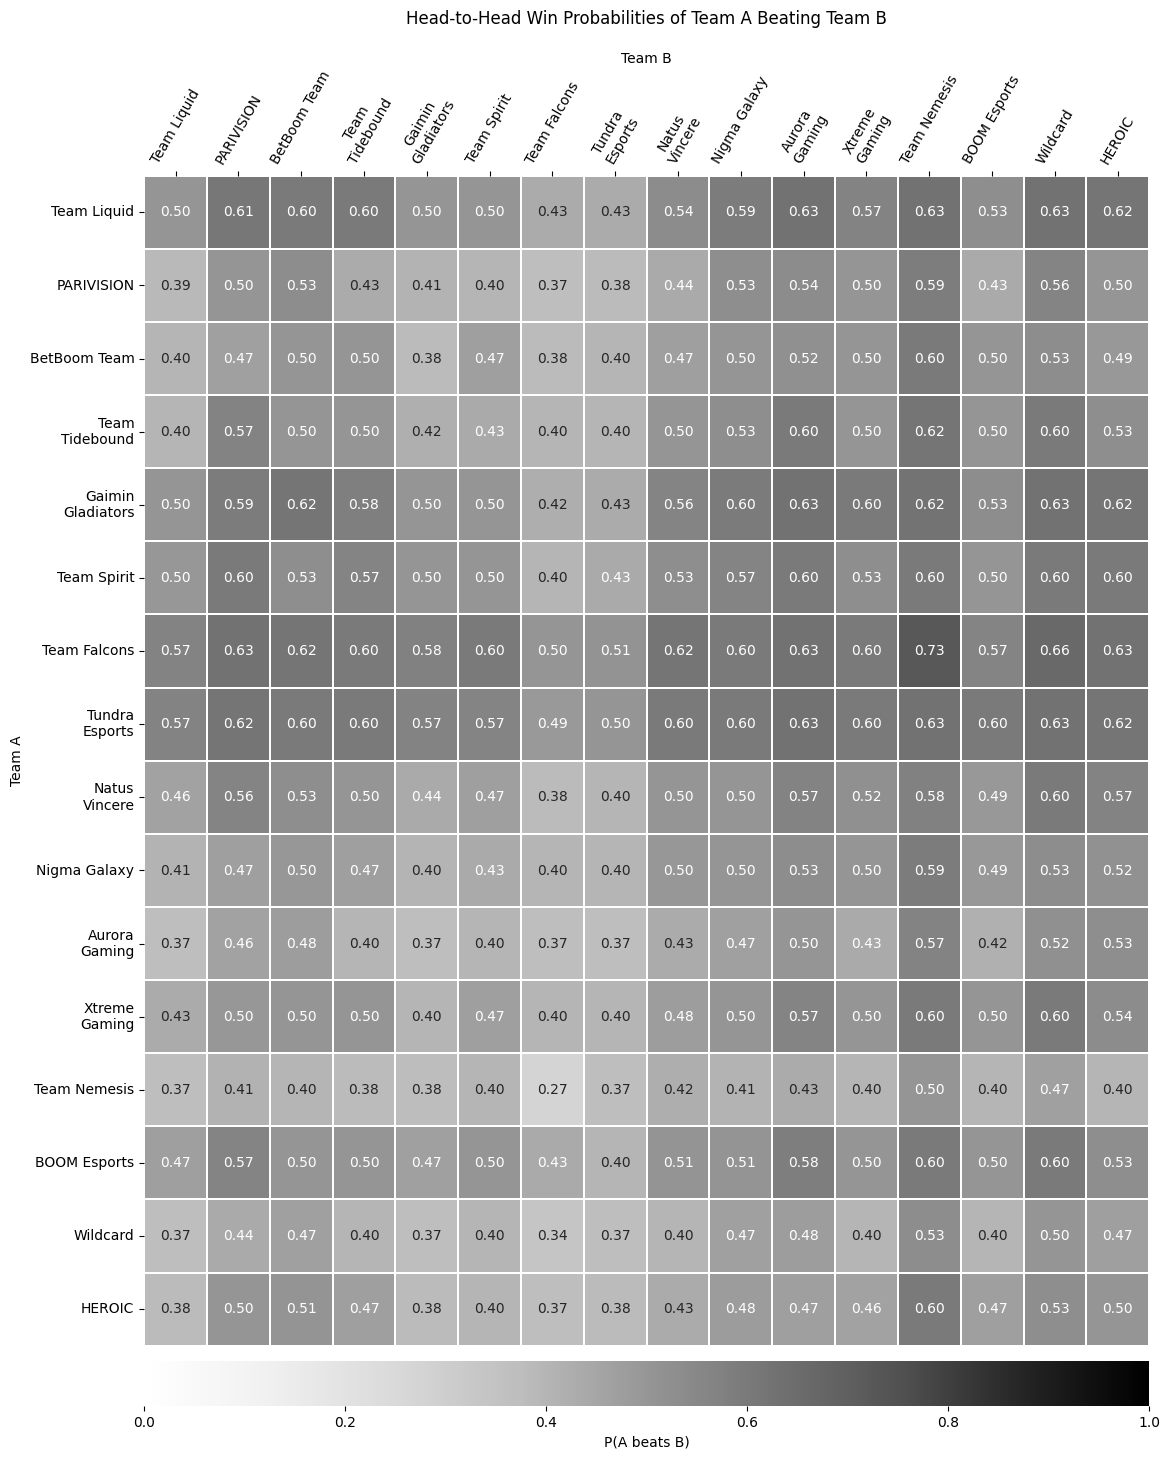

In [6]:
def _prob_matrix_to_df(prob_matrix, team_ids, labels=None):
    if labels is None:
        labels = [ID2NAME[t] for t in team_ids]
    M = np.array([[prob_matrix[int(a)][int(b)] for b in team_ids] for a in team_ids])
    return pd.DataFrame(M, index=labels, columns=labels)

def plot_prob_heatmap_sns(prob_matrix, team_ids, *,
                          gray=True, reverse=False,
                          annot=True, fmt=".2f",
                          wrap_width=12, rotate_xticks=45,
                          square=False, figsize=None):
    # labels (wrapped so they don’t overlap)
    labels = [ID2NAME[t] for t in team_ids]
    if wrap_width:
        labels = ['\n'.join(textwrap.wrap(s, wrap_width)) for s in labels]

    df = _prob_matrix_to_df(prob_matrix, team_ids, labels)

    # roomy figure (auto-scales with n and label length)
    if figsize is None:
        n = len(team_ids)
        max_label_len = max(len(s) for s in labels)
        w = max(10, 0.5*n + 0.12*max_label_len)
        h = max(10, 0.5*n + 0.16*max_label_len)
        figsize = (w, h)

    cmap = "Greys" if gray else "viridis"
    if reverse:
        cmap += "_r"

    plt.figure(figsize=figsize)
    fig, ax = plt.subplots(figsize=figsize)

    # reserve a short strip at the bottom for the colorbar
    cbar_ax = fig.add_axes([0.28, 0.08, 0.67, 0.03])  # [left, bottom, width, height] in figure coords

    sns.heatmap(
        df, vmin=0, vmax=1, cmap=cmap,
        annot=annot, fmt=fmt,
        cbar=True, cbar_ax=cbar_ax,
        cbar_kws={"orientation": "horizontal", "label": "P(A beats B)"},
        ax=ax, square=square, linewidths=0.3, linecolor="white"
    )

    # put column labels on top, rotate them for clearance
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')   # <-- move the x-axis title to the top
    ax.tick_params(axis="x", rotation=rotate_xticks, labelsize=10)
    ax.tick_params(axis="y", rotation=0, labelsize=10)

    # extra breathing room for long names and the colorbar
    plt.subplots_adjust(left=0.28, bottom=0.12, right=0.95, top=0.90)

    ax.set_xlabel("Team B")
    ax.set_ylabel("Team A")
    ax.set_title("Head-to-Head Win Probabilities of Team A Beating Team B", pad=20)

    plt.show()
plot_prob_heatmap_sns(PROB_MATRIX, TEAM_IDS, gray=True, reverse=False, wrap_width=12, rotate_xticks=60,figsize=(15,15))


In [7]:
# B) Deterministic Round-1 from JSON seeds, 1v16 (or "adjacent")
win_table_random_seeded_1v16, run_logs_seeded, stats_seeded = monte_carlo(
    N=10000, predictor=predictor, seed=123, verbose_every=1, capture_logs_for=1,
    random_seeding=True, pairing_style="1v16"
)
print("\n=== Estimated Title Odds (1v16) ===")
print(win_table_random_seeded_1v16)

Streaming output truncated to the last 5000 lines.

[Swiss] Final standings (pre-seed):
   1. PARIVISION  W-L=4-0  Buchholz=9
   2. BetBoom Team  W-L=4-1  Buchholz=12
   3. Team Falcons  W-L=4-1  Buchholz=11
   4. HEROIC  W-L=3-2  Buchholz=17
   5. Aurora Gaming  W-L=3-2  Buchholz=14
   6. Team Liquid  W-L=3-2  Buchholz=13
   7. BOOM Esports  W-L=3-2  Buchholz=11
   8. Natus Vincere  W-L=3-2  Buchholz=7
   9. Wildcard  W-L=2-3  Buchholz=14
  10. Xtreme Gaming  W-L=2-3  Buchholz=13
  11. Team Spirit  W-L=2-3  Buchholz=13
  12. Gaimin Gladiators  W-L=2-3  Buchholz=12
  13. Tundra Esports  W-L=2-3  Buchholz=6
  14. Team Nemesis  W-L=1-4  Buchholz=15
  15. Nigma Galaxy  W-L=1-4  Buchholz=13
  16. Team Tidebound  W-L=0-4  Buchholz=11

[Elimination Round] Pairings (Bo3): [('HEROIC', 'Tundra Esports'), ('Aurora Gaming', 'Gaimin Gladiators'), ('Team Liquid', 'Team Spirit'), ('BOOM Esports', 'Xtreme Gaming'), ('Natus Vincere', 'Wildcard')]
  - Elim: HEROIC vs Tundra Esports -> Tundra Esports 0-

In [8]:
# B) Deterministic Round-1 from JSON seeds, 1v16 (or "adjacent")
win_table_random_seeded_adjacent, run_logs_seeded, stats_seeded = monte_carlo(
    N=10000, predictor=predictor, seed=123, verbose_every=1, capture_logs_for=1,
    random_seeding=True, pairing_style="adjacent"
)
print("\n=== Estimated Title Odds (adjacent) ===")
print(win_table_random_seeded_adjacent)

Streaming output truncated to the last 5000 lines.

[Swiss] Final standings (pre-seed):
   1. PARIVISION  W-L=4-0  Buchholz=9
   2. BetBoom Team  W-L=4-1  Buchholz=12
   3. Team Falcons  W-L=4-1  Buchholz=11
   4. HEROIC  W-L=3-2  Buchholz=17
   5. Aurora Gaming  W-L=3-2  Buchholz=14
   6. Team Liquid  W-L=3-2  Buchholz=13
   7. BOOM Esports  W-L=3-2  Buchholz=11
   8. Natus Vincere  W-L=3-2  Buchholz=7
   9. Wildcard  W-L=2-3  Buchholz=14
  10. Xtreme Gaming  W-L=2-3  Buchholz=13
  11. Team Spirit  W-L=2-3  Buchholz=13
  12. Gaimin Gladiators  W-L=2-3  Buchholz=12
  13. Tundra Esports  W-L=2-3  Buchholz=6
  14. Team Nemesis  W-L=1-4  Buchholz=15
  15. Nigma Galaxy  W-L=1-4  Buchholz=13
  16. Team Tidebound  W-L=0-4  Buchholz=11

[Elimination Round] Pairings (Bo3): [('HEROIC', 'Tundra Esports'), ('Aurora Gaming', 'Gaimin Gladiators'), ('Team Liquid', 'Team Spirit'), ('BOOM Esports', 'Xtreme Gaming'), ('Natus Vincere', 'Wildcard')]
  - Elim: HEROIC vs Tundra Esports -> Tundra Esports 0-

In [30]:
PATCH_NUM = 7.39

predict_prematch_histgb, utils = load_prematch_histgb("prematch_histgb_artifacts.joblib")

def predictorModel(a_id, b_id, _model=predict_prematch_histgb, _patch=PATCH_NUM):
    out = _model(int(a_id), int(b_id), by="id", patch_num=_patch, symmetrize=True)
    # Model returns symmetric prob under 'p_radiant_win_sym'
    return float(out["p_radiant_win_sym"])

# Benchmark model path
def bench_model_once(predictor, pairs, reps=1000):
    t0 = time.perf_counter()
    r = random.random
    for _ in range(reps):
        for a,b in pairs:
            p = predictor(a,b)
            _ = (r() < p)
    return time.perf_counter() - t0

# Benchmark lookup path
def bench_lookup_once(prob_matrix, pairs, reps=1000):
    t0 = time.perf_counter()
    r = random.random
    for _ in range(reps):
        for a,b in pairs:
            p = prob_matrix[a][b]
            _ = (r() < p)
    return time.perf_counter() - t0

pairs = [(TEAM_IDS[i], TEAM_IDS[j]) for i in range(len(TEAM_IDS)) for j in range(len(TEAM_IDS)) if i!=j]
random.shuffle(pairs)
print("Model secs:", bench_model_once(predictorModel, pairs[:120], reps=10))
print("Lookup secs:", bench_lookup_once(PROB_MATRIX, pairs[:120], reps=10))

Model secs: 48.88697838100052
Lookup secs: 0.00020328100072219968
